# Analysis
* Create yml for all my files. 
* Save overlay? 

In [1]:
import altair as alt
import fsspec
import geopandas as gpd
import intake
import numpy as np
import pandas as pd
import utilities
from calitp import *
from IPython.display import HTML, Image, Markdown, display, display_html
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

In [4]:
routes_df = utilities.load_unique_routes_df()

In [5]:
routes_df.shape

(2501, 7)

## T-Mobile

In [6]:
tmobile_df = gpd.read_parquet(f"{GCS_FILE_PATH}tmobile_california.parquet")

In [7]:
tmobile_m1 = utilities.route_cell_coverage(tmobile_df, routes_df, "_tmobile")

In [8]:
tmobile_m1.shape

(2500, 9)

In [9]:
(tmobile_m1["binned_tmobile"].value_counts() / len(tmobile_m1)) * 100

(90, 100]   71.76
(80, 90]     6.52
(70, 80]     2.64
(60, 70]     0.92
(50, 60]     0.48
(40, 50]     0.44
(30, 40]     0.28
(20, 30]     0.16
(10, 20]     0.04
(0, 10]      0.00
Name: binned_tmobile, dtype: float64

## AT&T

In [10]:
att_df = utilities.load_att()

In [11]:
att_m1 = utilities.route_cell_coverage(att_df, routes_df, "_att")

In [12]:
att_m1.shape

(2494, 9)

In [13]:
(att_m1["binned_att"].value_counts() / len(att_m1)) * 100

(90, 100]   73.78
(80, 90]     5.33
(70, 80]     2.13
(60, 70]     1.08
(50, 60]     0.60
(10, 20]     0.12
(0, 10]      0.08
(20, 30]     0.08
(30, 40]     0.08
(40, 50]     0.08
Name: binned_att, dtype: float64

In [ ]:
#att_m1.loc[att_m1['agency'] == "Roseville Transit"].drop(columns = ['geometry_overlay_att'])

## Verizon
* Verizon has the best coverage. 85% of the routes have 90% or more coverage with Verizon. 

In [15]:
verizon_df = utilities.load_verizon()

In [16]:
verizon_m1 = utilities.route_cell_coverage(verizon_df, routes_df, "_verizon")

In [17]:
verizon_m1.shape

(2494, 9)

In [18]:
(verizon_m1["binned_verizon"].value_counts() / len(verizon_m1)) * 100

(90, 100]   86.37
(80, 90]     6.13
(70, 80]     2.21
(60, 70]     0.84
(50, 60]     0.72
(0, 10]      0.08
(30, 40]     0.08
(40, 50]     0.08
(10, 20]     0.04
(20, 30]     0.00
Name: binned_verizon, dtype: float64

## Merge all three providers

In [19]:
common_cols = ["route_id", "route_name", "agency", "itp_id", "route_length_original_df"]

In [20]:
merge1 = att_m1.merge(verizon_m1, how="outer", on=common_cols).merge(
    tmobile_m1, how="outer", on=common_cols
)

In [21]:
# Del extra cols that are the same across dfs.
merge1 = merge1.drop(
    columns=[
        "binned_verizon",
        "binned_att",
        "binned_tmobile",
    ]
)

In [22]:
# Ensure this remains a gdf.
merge1 = gpd.GeoDataFrame(merge1, geometry="geometry_overlay_verizon", crs="EPSG:4326")

In [23]:
type(merge1)

geopandas.geodataframe.GeoDataFrame

In [24]:
merge1.shape

(2500, 14)

### Some checks
* Original df against merged.

In [25]:
# 1 extra row missing??
routes_df.shape, merge1.shape

((2501, 7), (2500, 14))

In [26]:
# Find the missing row
original = set(routes_df.route_name.unique().tolist())
merge = set(merge1.route_name.unique().tolist())
original - merge

{'Arizona Western College/Northern Arizona University/University of Arizona to Wellton via Fortuna Foothills'}

In [27]:
routes_df.route_id.nunique(), merge1.route_id.nunique()

(1719, 1719)

In [28]:
routes_df.itp_id.nunique(), merge1.itp_id.nunique()

(150, 150)

### Route Coverage - using median % of coverage across 3 providers.
* 78% of routes have 90-100% of coverage. 

In [29]:
# Create a column with median of all three providers
merge1["median_cell_coverage_percentage"] = merge1[
    ["percentage_verizon", "percentage_tmobile", "percentage_att"]
].median(axis=1)

In [30]:
# Bin the median?
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [31]:
(pd.cut(merge1["median_cell_coverage_percentage"],bins).value_counts()  / len(merge1)) * 100

(90, 100]   78.96
(80, 90]     5.44
(70, 80]     2.00
(60, 70]     0.92
(50, 60]     0.64
(30, 40]     0.16
(40, 50]     0.16
(0, 10]      0.08
(10, 20]     0.08
(20, 30]     0.00
Name: median_cell_coverage_percentage, dtype: float64

### Filter out for low threshold 
* Using the median cell coverage percentage, choose 70% or less cell coverage as the threshold.

In [32]:
threshold = 70

In [33]:
# Filter based on median
low_coverage = merge1[
    (merge1["median_cell_coverage_percentage"] < threshold)]

In [34]:
len(low_coverage), type(low_coverage), low_coverage.route_id.nunique()

(51, geopandas.geodataframe.GeoDataFrame, 51)

In [35]:
# (low_coverage.loc[:,~low_coverage.columns.str.contains('^geometry', case=False)])

## Add trips
* Add one column for total trips that an agency completes across all routes.
* Add another column for total trips ONLY for routes with low coverage. 
* Divide these 2 columns for percentage of trips an agency runs in a low coverage zone.
* Fill NA for total trips by agency/by route with median of each col

In [36]:
trips = utilities.trip_df()

In [37]:
# Merge the 2 filtered at&t and verizon dataframes so we can see which routes overlap
trips_routes = pd.merge(
    low_coverage,
    trips,
    how="left",
    left_on=["itp_id", "route_id"],
    right_on=["calitp_itp_id", "route_id"],
    indicator=True,
)

In [38]:
# Should all route ids match?
trips_routes["_merge"].value_counts()

both          48
left_only      3
right_only     0
Name: _merge, dtype: int64

In [39]:
trips_routes.total_trips_by_route.median(), trips_routes.total_trips_by_agency.median()

(8.0, 137.5)

In [40]:
# Fill NA for total trips by agency/by route with median of each col
trips_routes = trips_routes.assign(
     total_trips_by_route = trips_routes.total_trips_by_route.fillna(trips_routes.total_trips_by_route.median()),
     total_trips_by_agency = trips_routes.total_trips_by_agency.fillna(trips_routes.total_trips_by_agency.median())
) 

In [41]:
# Add column for percentage of trips for the route in question compared with
# All the trips an agency has done
trips_routes["percentage_of_trips_w_low_cell_service"] = (
    trips_routes["total_trips_by_route"] / trips_routes["total_trips_by_agency"]
)

In [42]:
trips_routes = trips_routes.drop(columns=["_merge", "calitp_itp_id"])

## Add NTD

In [43]:
# Load NTD vehicles
ntd_df = utilities.ntd_vehicles()[["agency", "total_buses"]]

In [44]:
# ntd_df.agency.unique()

In [45]:
# Replace agency names in NTD to match routes_df above
ntd_df["agency"] = ntd_df["agency"].replace(
    {
        "Trinity County": "Trinity Transit",
        "City of Calabasas": "Calabasas Transit System",
        "County of Sonoma": "Sonoma County Transit",
        "Tehama County": "Tehama Rural Area eXpress",
        "Los Angeles County Department of Public Works - East L.A.": "East Los Angeles Shuttle",
        "Sacramento Regional Transit District": "Sacramento Regional Transit District",
        "Eastern Sierra Transit Authority": "Mammoth Lakes Transit System",
        "City of Lompoc": "City of Lompoc Transit",
        "San Luis Obispo Regional Transit Authority": "South County Transit Link",
        "City of Roseville": "Roseville Transit",
        "Los Angeles County Dept. of Public Works - Athens Shuttle Service": "the Link-Athens",
        "Los Angeles County Department of Public Works - Avocado Heights": "Avocado Heights/Bassett/West Valinda Shuttle",
        "Susanville Indian Rancheria": "Susanville Indian Rancheria Public Transportation Program",
        "Transit Joint Powers Authority for Merced County": "Merced The Bus",
        "City of Eureka": "Eureka Transit Service",
        "Nevada County Transit Services": "Gold Country Stage",
        "San Mateo County Transit District": "SamTrans",
        "Redwood Coast Transit Authority": "Redwood Coast Transit",
        "City of Avalon": "Avalon Transit",
        "City of Lodi": "Grapeline",
        "Golden Gate Bridge": "Golden Gate Bridge Highway and Transportation District",
        "City of Santa Maria": "Santa Maria Area Transit",
        'City and County of San Francisco': 'MUNI',
        'Alameda-Contra Costa Transit District': 'AC Transit',
        'Kern Regional Transit': 'Kern Transit',
        'County of Placer': 'Tahoe Transportation',
        'County of Placer':'Tahoe Truckee Area Regional Transportation'
    }
)

In [46]:
# Replace agency names in agency4 to match ntd
trips_routes["agency"] = trips_routes["agency"].replace(
    {
        "Cloverdale Transit": "Sonoma County Transit",
    }
)

In [47]:
# Merge
trips_routes_ntd = pd.merge(
    trips_routes,
    ntd_df,
    how="left",
    on="agency",
    indicator=True,
)

#### Estimate # of buses that run in low cellular coverage areas
* Create col to estimate number of buses that run in low cell coverage routes based on % of trips ran for the low coverage routes out of total trips. 
* Multiply the aforementioend percentage by total buses.
* Fill missing values for total buses & total buses run in low coverage zones columns with the median of each. 
* Fill values of 0 with 1, since at least one bus ran through that route. 

In [48]:
# Fill na with median total buses
median_total_buses = trips_routes_ntd["total_buses"].median()
median_total_buses

35.0

In [49]:
trips_routes_ntd["total_buses"] = trips_routes_ntd["total_buses"].fillna(median_total_buses)

In [50]:

trips_routes_ntd["estimate_of_buses_in_low_cell_zones"] = (
    (trips_routes_ntd["total_buses"] * trips_routes_ntd["percentage_of_trips_w_low_cell_service"]
    )
    .fillna((trips_routes_ntd["total_buses"] * trips_routes_ntd["percentage_of_trips_w_low_cell_service"]
    ).median())
    .astype('int64')
   
)

In [51]:
# Fill 0 with 1?
trips_routes_ntd["estimate_of_buses_in_low_cell_zones"] = trips_routes_ntd[
    "estimate_of_buses_in_low_cell_zones"
].replace({0: 1})


## Final

### There are a lot of same route-id and same route-name combos but run by different agencies.
* Scanned [agencies](https://github.com/cal-itp/data-infra/blob/main/airflow/data/agencies.yml) to make sure all duplicates lead to the same gtsf schedule url.
* If so, del duplicates.

In [52]:
trips_routes_ntd.route_id.value_counts().head(10)

1042    1
6       1
3       1
30      1
3572    1
41      1
42      1
5490    1
561     1
566     1
Name: route_id, dtype: int64

In [53]:
# Del duplicates based on whichever agency with the same route has the most buses.
final = trips_routes_ntd.sort_values(
    ["route_id", "route_name", "total_buses"], ascending=[True, True, False]
).drop_duplicates(subset=["route_id", "route_name"])

In [54]:
final.shape, final.route_id.nunique(), type(final)

((51, 21), 51, geopandas.geodataframe.GeoDataFrame)

In [55]:
# Set geometry.
final = final.set_geometry("geometry_overlay_verizon")

### Results
* Some of the results are surprising...wouldn't expect urban areas to have routes on this list
* Also there is one Arizona route here? 

In [119]:
# https://stackoverflow.com/questions/38383886/drop-column-based-on-a-string-condition
final.loc[:, ~final.columns.str.contains("route_length|geometry|_merge|percentage_")].sort_values(
    "route_id"
)

,route_id,agency,itp_id,route_name,median_cell_coverage_percentage,total_trips_by_route,total_trips_by_agency,total_buses,estimate_of_buses_in_low_cell_zones
49,10,Yuma County Area Transit,386,"Downtown Yuma Transit Center to Fortuna Foothills via Arizona Western College, University of Arizona and Northern Arizona University and 32nd Street",18.32,34.00,139.00,35.00,8
0,1042,Sonoma County Transit,70,"Guerneville, Monte Rio",45.53,8.00,257.00,77.00,2
1,120,Redwood Coast Transit,261,Route 20 Smith River / Arcata,60.33,11.00,63.00,14.00,2
2,1210,Merced The Bus,343,Planada Commuter,67.60,10.00,629.00,67.00,1
3,12133,Tahoe Transportation,331,South Shore Service & Lake Express Daily,0.62,8.00,137.50,35.00,2
4,12135,Tahoe Transportation,331,Valley Express Daily,0.80,8.00,137.50,35.00,2
5,12181,Tulare County Area Transit,346,Porterville to Springville Loop,52.20,4.00,137.00,24.00,1
6,1292,Susanville Indian Rancheria Public Transportation Program,329,None,51.67,2.00,60.00,4.00,1
7,13050,Avocado Heights/Bassett/West Valinda Shuttle,171,Avocado Heights/Bassett/West Valinda Shuttle,67.46,23.00,501.00,4.00,1
8,13054,Avocado Heights/Bassett/West Valinda Shuttle,171,Edmund D. Edelman Children’s Court Shuttle,53.88,49.00,501.00,4.00,1


#### How many total buses? Routes? 

In [120]:
f"{final.estimate_of_buses_in_low_cell_zones.sum()} total buses running in areas with low cell coverage & {final.route_id.nunique()} different routes."

'161 total buses running in areas with low cell coverage & 51 different routes.'

#### How often do agencies appear?

In [121]:
final.agency.value_counts()

Tahoe Truckee Area Regional Transportation                   4
Trinity Transit                                              4
Mendocino Transit Authority                                  3
Santa Cruz Metropolitan Transit District                     3
Roseville Transit                                            2
Yosemite Area Regional Transportation System                 2
Eastern Sierra Transit Authority                             2
City of Lompoc Transit                                       2
Sonoma County Transit                                        2
SamTrans                                                     2
Yuma County Area Transit                                     2
Tahoe Transportation                                         2
Redwood Coast Transit                                        2
Avocado Heights/Bassett/West Valinda Shuttle                 2
Susanville Indian Rancheria Public Transportation Program    2
Golden Gate Bridge Highway and Transportation District 

#### Checking with original dataframes
* Explore why there are some urban areas that appear in the final dataframe?

In [122]:
# Grab route ID & agency
final_routes = final[["route_id", "agency"]]

In [123]:
final_routes_list = final.route_id.unique().tolist()

In [124]:
# Only keep final routes in the original routes_df
routes_original_df = pd.merge(routes_df, final_routes, how="inner", on=["route_id", "agency"])

In [125]:
"""
final_routes_merge.loc[:, ~final_routes_merge.columns.str.contains("itp_id|geometry|_merge")].sort_values(
    "route_id"
)
"""

'\nfinal_routes_merge.loc[:, ~final_routes_merge.columns.str.contains("itp_id|geometry|_merge")].sort_values(\n    "route_id"\n)\n'

In [126]:
routes_original_df.explore(
    "route_id",
    width=800,
    height=400,
    tooltip=["route_name", "agency", "route_id"],
    style_kwds={"weight": 6},
    legend=False,
    color="tab20c",
)

### Testing - why are there urban areas in the results?
* Because has highest % of routes with 90-100% data coverage.

In [127]:
def comparison(gdf_left, gdf_right):

    # Overlay
    overlay_df = gpd.overlay(
        gdf_left, gdf_right, how="intersection", keep_geom_type=True
    )

    # Create a new route length for portions covered by cell coverage
    overlay_df = overlay_df.assign(
        route_length=overlay_df.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

    return overlay_df

In [128]:
# Subset original df
routes_test= routes_df[routes_df["agency"].isin(["Sacramento Regional Transit District", "Golden Gate Bridge Highway and Transportation District"])]

In [129]:
routes_test.shape

(80, 7)

In [130]:
# Break out comparison function in utilities
verizon_test = gpd.overlay(
        routes_test, verizon_df, how="intersection", keep_geom_type=False
    )

In [131]:
verizon_test=verizon_test.to_crs(geography_utils.CA_StatePlane)

In [132]:
verizon_test["route_length"] = verizon_test.geometry.to_crs(geography_utils.CA_StatePlane).length

#### Sac Route 30

In [133]:
# Original dataframe
sac_og = routes_test[(routes_test['route_id'] == "30")]
sac_og.drop(columns = ['geometry'])

,itp_id,route_id,route_type,route_name,agency,route_length
1518,273,30,3,FSL,Sacramento Regional Transit District,55102.22


<AxesSubplot:>

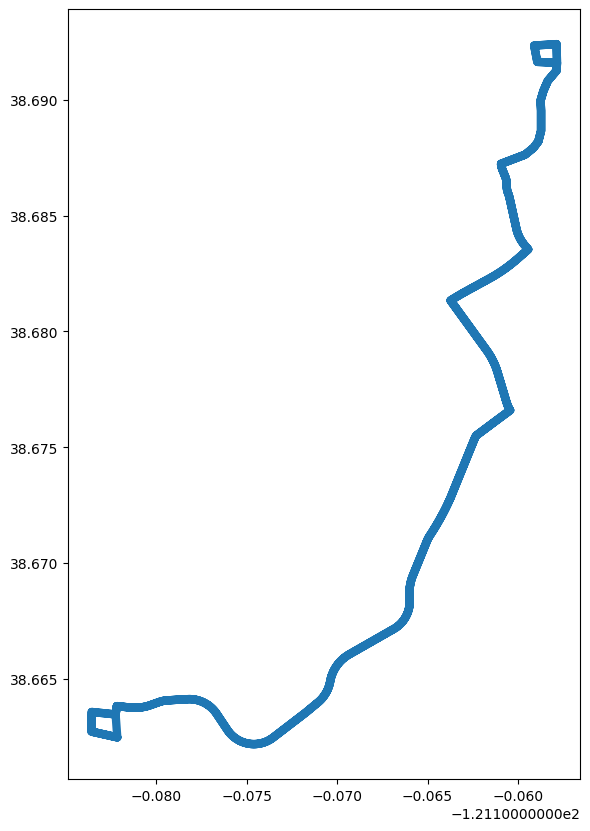

In [134]:
sac_og.plot(figsize=(10,10), lw=6 )

In [135]:
# Only the comparison length: intersect Verizon df with Routes df & grab the length 
sac_verizon = verizon_test[(verizon_test['route_id'] == "30")]
sac_verizon.drop(columns = ['geometry'])

,itp_id,route_id,route_type,route_name,agency,route_length
100,273,30,3,FSL,Sacramento Regional Transit District,19248.17


<AxesSubplot:>

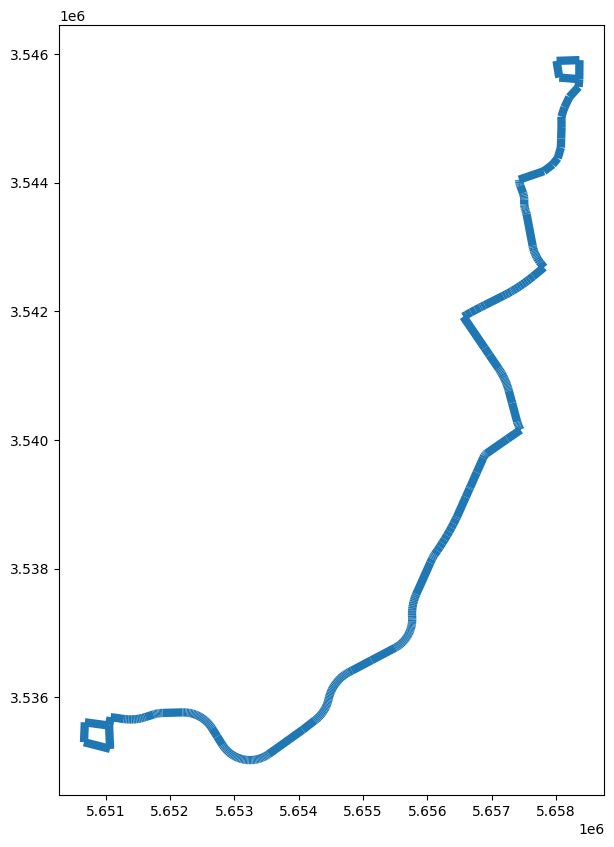

In [136]:
sac_verizon.plot(figsize=(10,10), lw=6)

In [137]:
# The original routes_cell_coverage function
verizon_m1[(verizon_m1['agency'] == "Sacramento Regional Transit District") & (verizon_m1['route_id'] == "30")].drop(columns = ['geometry_overlay_verizon'])

,route_id,agency,itp_id,route_length_overlay_verizon,route_name,route_length_original_df,percentage_verizon,binned_verizon
985,30,Sacramento Regional Transit District,273,19248.17,FSL,55102.22,34.93,"(30, 40]"


#### Golden Gate Bridge Highway and Transportation District 705-240

In [138]:
# Original dataframe
sf_og = routes_test[(routes_test['agency'] == "Golden Gate Bridge Highway and Transportation District") & (routes_test['route_id'] == "705-240")]

<AxesSubplot:>

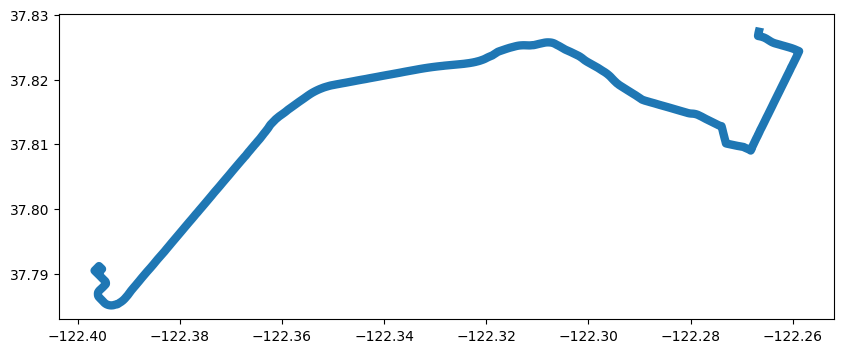

In [139]:
sf_og.plot(figsize=(10,10), lw=6 )

In [140]:
# Intersection between original routes & verizon.
# Split? 
sf_test = verizon_test[(verizon_test['agency'] == "Golden Gate Bridge Highway and Transportation District") & (verizon_test['route_id'] == "705-240")] 
sf_test.drop(columns = ['geometry'])

,itp_id,route_id,route_type,route_name,agency,route_length
15,127,705-240,3,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation District,9725.39
40,127,705-240,3,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation District,28044.65


In [141]:
sf_test.route_length.sum()

37770.03966253376

<AxesSubplot:>

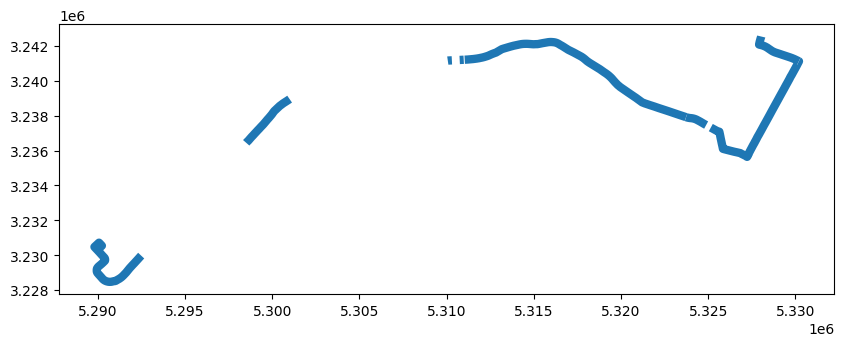

In [142]:
sf_test.plot(figsize=(10,10), lw=6 )

In [143]:
(28044.65+9725.39)/56918.54

0.663580618898517

In [144]:
# The entire function route_cell_coverage
verizon_m1[(verizon_m1['agency'] == "Golden Gate Bridge Highway and Transportation District") & (verizon_m1['route_id'] == "705-240")].drop(columns = ['geometry_overlay_verizon'])

,route_id,agency,itp_id,route_length_overlay_verizon,route_name,route_length_original_df,percentage_verizon,binned_verizon
1926,705-240,Golden Gate Bridge Highway and Transportation District,127,37770.04,Oakland - San Francisco,56918.54,66.36,"(60, 70]"
